In [1]:
import csv
import re
from itertools import takewhile

def parse_arff(arff):
    """Parses arff file"""
    r_datatag = re.compile('^@data', flags=re.IGNORECASE)
    header = list(takewhile(lambda line: not r_datatag.match(line), arff))
    
    r_attrname = re.compile('^@attribute\s([\w.]+)\s.*', flags=re.IGNORECASE)
    attrnames = []
    for line in header:
        try:
            name = r_attrname.match(line).group(1)
        except AttributeError:
            continue
        name = name.replace('.', '_') # dots make fieldnames invalid
        attrnames.append(name)
        
    data = csv.reader(arff)

    return attrnames, data

In [58]:
import numpy as np
import pandas as pd

with open("CWData_train.remove_missing.reduce_duplicates.outliers.arff") as arff:
    attrnames, data = parse_arff(arff)
    
    df = pd.DataFrame(data, columns=attrnames, dtype='category')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53


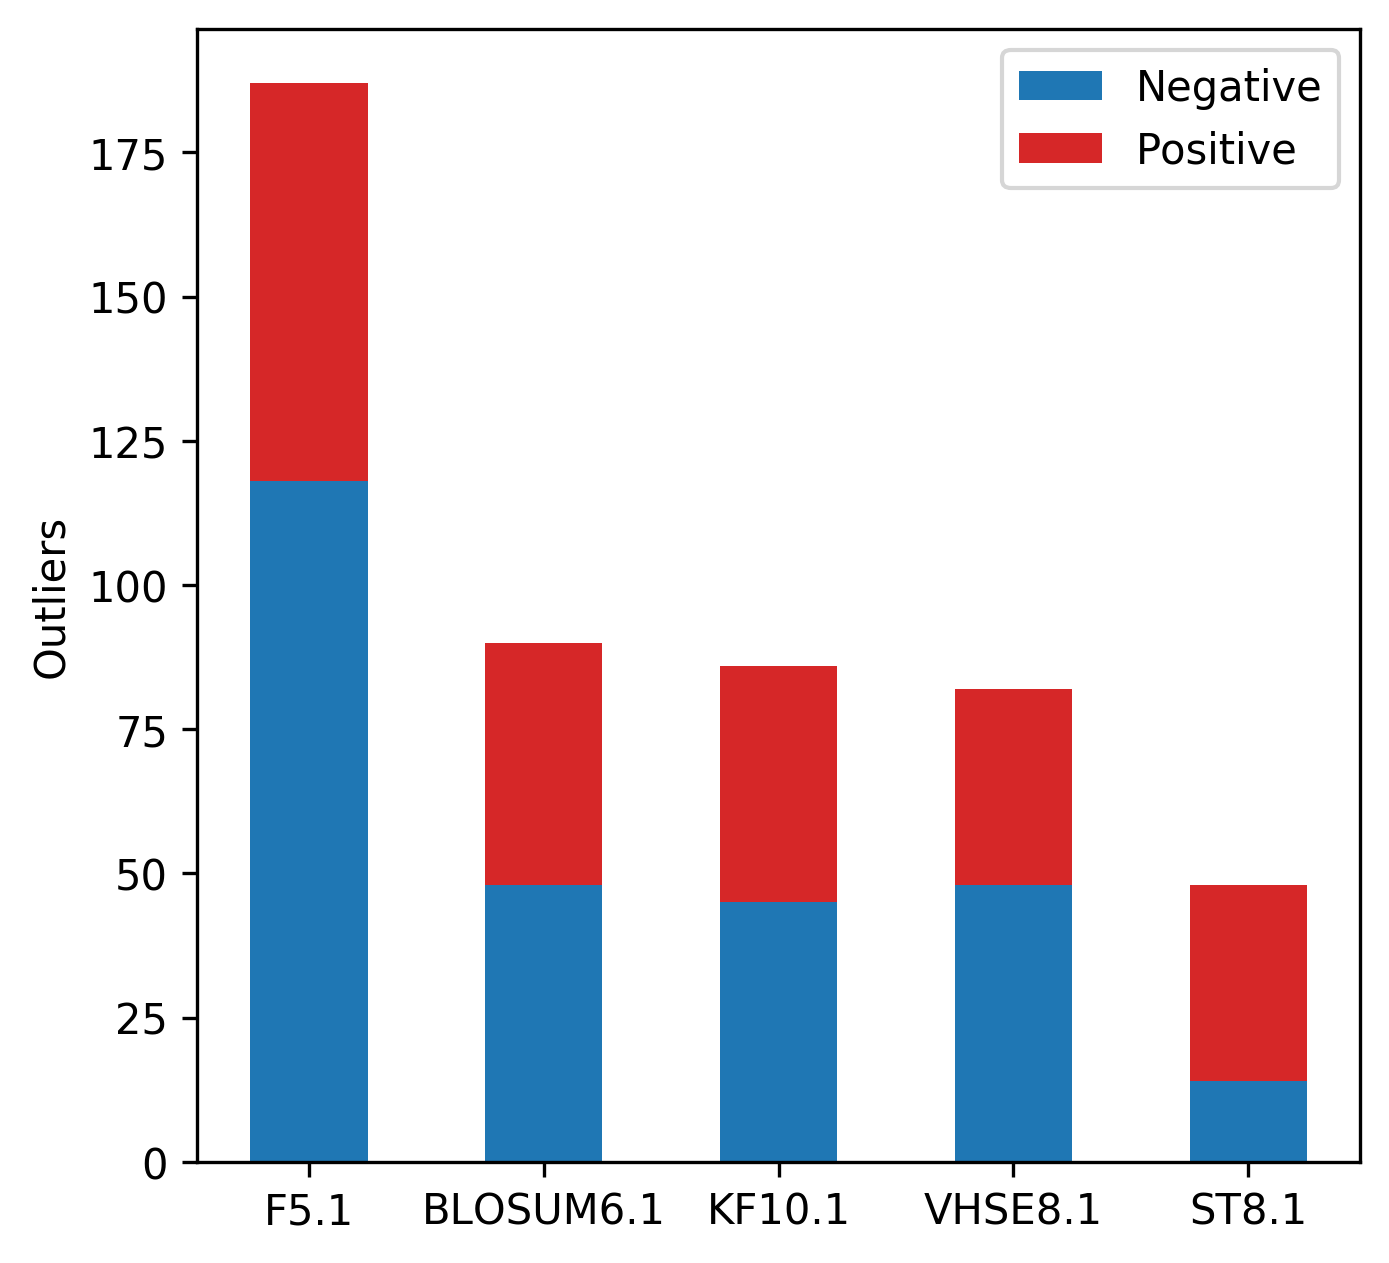

In [132]:
# https://stackoverflow.com/a/50205834/5193926

import matplotlib.pyplot as plt

def plot_stacked_bar(data, series_labels, category_labels=None, 
                     show_values=False, value_format="{}", y_label=None, 
                     colors=None, grid=True, reverse=False):
    """Plots a stacked bar chart with the data and labels provided.

    Keyword arguments:
    data            -- 2-dimensional numpy array or nested list
                       containing data for each series in rows
    series_labels   -- list of series labels (these appear in
                       the legend)
    category_labels -- list of category labels (these appear
                       on the x-axis)
    show_values     -- If True then numeric value labels will 
                       be shown on each bar
    value_format    -- Format string for numeric value labels
                       (default is "{}")
    y_label         -- Label for y-axis (str)
    colors          -- List of color labels
    grid            -- If True display grid
    reverse         -- If True reverse the order that the
                       series are displayed (left-to-right
                       or right-to-left)
    """
    plt.figure(num=None, figsize=(5,5), dpi=300)

    ny = len(data[0])
    ind = [x for x in range(ny)]

    axes = []
    cum_size = np.zeros(ny)

    data = np.array(data)

    if reverse:
        data = np.flip(data, axis=1)
        category_labels = reversed(category_labels)

    for i, row_data in enumerate(data):
        axes.append(plt.bar(ind, row_data, bottom=cum_size, 
                            label=series_labels[i], color=colors[i],
                            width=0.5))
        cum_size += row_data

    if category_labels:
        plt.xticks(ind, category_labels)

    if y_label:
        plt.ylabel(y_label)

    plt.legend()

    if grid:
        plt.grid()

    if show_values:
        for axis in axes:
            for bar in axis:
                w, h = bar.get_width(), int(bar.get_height())
                plt.text(bar.get_x() + w/2, bar.get_y() + h/2, 
                         value_format.format(h), ha="center", 
                         va="center")

###

from collections import namedtuple
import re

r_attr = re.compile('(.*)_Outlier')

Outliers = namedtuple('Outliers', ['neg', 'pos'])
    
outliers_dict = {}
for column in (column for column in df if column != 'Class'):
    attr = r_attr.match(column).group(1).replace('_', '.')
    
    try:
        df[column].value_counts()['yes']
    except:
        continue
    negative_outliers = df.loc[df['Class'] == 'Negative', column].value_counts()['yes']
    positive_outliers  = df.loc[df['Class'] == 'Positive', column].value_counts()['yes']
    
    outliers_dict[attr] = Outliers(negative_outliers, positive_outliers)
    
outliers_dict = dict(sorted(outliers_dict.items(), key=lambda item: item[1].neg + item[1].pos, reverse=True))

attrs = outliers_dict.keys()

neg_data = [outliers.neg for outliers in outliers_dict.values()][:5]
pos_data = [outliers.pos for outliers in outliers_dict.values()][:5]

plot_stacked_bar([neg_data, pos_data], ['Negative', 'Positive'],
                 category_labels=attrs,
                 colors=['tab:blue', 'tab:red'],
                 grid=False,
                y_label="Outliers")